# Image Retrieval
Progetto dalle immagini di pokemon a riconoscimento di animali

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2, ResNet50, resnet50
keras.__version__

'2.4.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import dipinti
import zipfile, os
# this would take very long !!!
base_dir = '/content/drive/MyDrive/Magistrale/II anno/Image signal/DSIM_project/image retrieval'
zip = zipfile.ZipFile(f'{base_dir}/train_1.zip')
zip.extractall()
zip.close()

### Import reti 

In [4]:
my_resnet50 = ResNet50(include_top = False, weights='imagenet',
                       pooling = 'max', input_shape=(224,224,3))

94773248/94765736 [==============================] - 0s 0us/step


In [5]:
# tagliamo la rete al livello flatten
my_mobilenet_v2 = mobilenet_v2.MobileNetV2(include_top=False, weights = 'imagenet', 
                               pooling = 'max', input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


### Funzioni per caricare il dataset di immagini di base

In [6]:
def mobilenet_v2_features(img, net):
    '''
      Takes an image in order to extract the features of mobilenet_v2
      @params:
        - img: image to compute
        - net: neural network to use
    '''
    x = kimage.img_to_array(img) # to numpy
    x = mobilenet_v2.preprocess_input(x) # preprocess for network
    x = np.expand_dims(x, axis=0) # necessario per la rete
    features = net.predict(x).flatten()
    return features

In [7]:
def resnet50_features(img, net):
    '''
      Takes an image in order to extract the features of mobilenet_v2
      @params:
        - img: image to compute
        - net: neural network to use
    '''
    x = kimage.img_to_array(img) # to numpy
    x = resnet50.preprocess_input(x) # preprocess for network
    x = np.expand_dims(x, axis=0) # necessario per la rete
    features = net.predict(x).flatten()
    return features

In [8]:
# Limit number of loaded images
maximages = 500

# Dummy feature - esempio giocattolo
#def identity(image):
#    return kimage.img_to_array(img).flatten()

# Data loader
def load_data(base_path, net, feature_extractor=mobilenet_v2_features):
    '''
      Load image database features by applying feature extraction of a neural network
      @params:
        - base_path: path where folders of classes of images are stored
        - feature_extractor: function that extracts features on a image
        - preprocess_fuction: function to apply to image in order to insert it 
              in the neural network
        - net: neural network to apply
    '''
    paths = []
    features = []

    for file_n, f in enumerate(sorted(os.listdir(base_path))):
      if f.endswith('.jpg'):
        # Save file path
        cur_path = base_path + f
        paths.append(cur_path)
        
        # Load file and extract features
        image = kimage.load_img(cur_path, target_size=(224, 224, 3))
        cur_features = feature_extractor(image, net)
        features.append(cur_features)
      
      if file_n % 100 == 0: print(f"{i} images loaded")
      if (file_n > maximages) :
        break

    features = np.array(features)
    return features, paths

### Load images

In [9]:
# carico img di base + paths
jpg_path = f"/content/train_1/"
X_train, paths = load_data(jpg_path, feature_extractor=resnet50_features, net = my_resnet50)
X_train.shape

(502, 2048)

Usiamo un KDTree per suddividere lo spazio di ricerca (**ALTRI????**)

In [11]:
from sklearn.neighbors import KDTree
tree = KDTree(X_train)

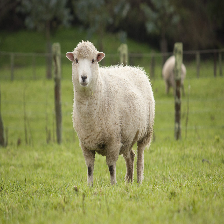

In [35]:
# carico immagine di query + estraggo le sue features
query_image = kimage.load_img(f'{base_dir}/images_paintings_test/sheep.jpg', target_size=(224, 224, 3))
query_features = resnet50_features(query_image, my_resnet50)
query_features = np.expand_dims(query_features, axis = 0)
#plot image
query_image

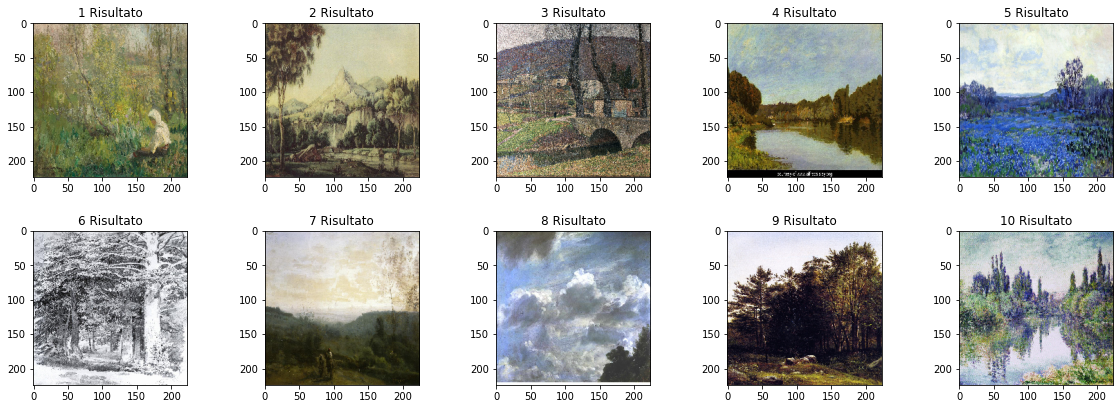

In [36]:
# ricerca nello spazio 
dist, ind = tree.query(query_features, k=10)

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize=(10,7))
for j in range(2):
  for i in range(5):
    im = kimage.load_img(paths[ind[0][i+j*5]], target_size=(224,224,3))
    axs[j][i].imshow(im)
    axs[j][i].set_title(f"{5*j+i+1} Risultato")
plt.subplots_adjust(left = 0.2, right= 1.7, wspace = 0.5)
